In [84]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import  Pipeline
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [86]:
df = pd.read_csv("tempdata.csv")
df.drop("Amount_of_chicken",axis=1,inplace=True)
df.head()

,Temperature,Humidity,AQI,WQI,Humidex
0,29.3,51.7,21.957796,95.950538,35.016212
1,29.3,52.3,8.731716,88.559769,35.822153
2,29.3,52.5,8.402340,93.361755,34.277358
3,29.3,49.7,14.466574,98.947226,33.320641
4,29.2,51.4,15.774947,94.584586,30.619136


In [87]:
X = df.drop("Humidex",axis=1)
y= df["Humidex"]

In [91]:
# 1. Split first
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Then fit preprocessing only on training data
preprocessor_feature = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor_label = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])



X_train_processed = preprocessor_feature.fit_transform(X_train)
y_train_processed = preprocessor_label.fit_transform(y_train.values.reshape(-1, 1)).flatten()

## Saving the label encoder and preprocessor

In [92]:
# Save the fitted LabelEncoder
joblib.dump(preprocessor_feature,'artifacts/preprocessor_feature.joblib')
joblib.dump(preprocessor_label,'artifacts/preprocessor_label.joblib')



['artifacts/preprocessor_label.joblib']

## Loading the label encoder

In [93]:
# Load the LabelEncoder
preprocessor_feature = joblib.load('artifacts/preprocessor_feature.joblib')
preprocessor_label = joblib.load('artifacts/preprocessor_label.joblib')

In [94]:
X_val_processed = preprocessor_feature.transform(X_val)
y_val_processed = preprocessor_label.transform(y_val.values.reshape(-1, 1)).flatten()


In [95]:
from torch.utils.data import  DataLoader, Dataset
## Create DataSetClass

class TabularDataset(Dataset):
    def __init__(self,X,y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if isinstance(y,pd.Series) else y,dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]

In [96]:
train_dataset = TabularDataset(X_train_processed,y_train)
val_dataset = TabularDataset(X_val_processed,y_val)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [97]:
class EarlyStopping():
    def __init__(self,patience=5,min_delta=1e-2,restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model_weights = None
        self.best_epoch = None
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, model, val_loss, epoch):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_weights = model.state_dict()
            self.best_epoch = epoch
            print(f"Current Best model found at epoch {epoch} with loss {val_loss:.4f}.")
        else:
            self.counter +=1
            print(f"Validation Loss: {val_loss:.4f} did not improve compared to best loss: {self.best_loss:.4f}. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop=True
                print(f"Early stopping triggered after {self.counter} checks without improvement.")
                if self.restore_best_weights and self.best_model_weights is not None:
                    model.load_state_dict(self.best_model_weights)

    def getBestModel(self,model):
        if self.restore_best_weights and self.best_model_weights is not None:
            print(f"✅ Restoring best model from epoch {self.best_epoch} with loss {self.best_loss:.4f}")
            model.load_state_dict(self.best_model_weights)

In [113]:
import torch.nn as nn

class TabularNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TabularNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            # nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model = TabularNet(input_dim=4, output_dim=1).to("cuda" if torch.cuda.is_available() else "cpu")


#### Get Helper Functions

In [114]:
def calculate_mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred)).item()

### Defining Train Test Loops

In [115]:
model.eval()
## Run a sample batch and use calulate mae
sample_batch = next(iter(val_loader))
X_sample, y_sample = sample_batch
X_sample = X_sample.to(device)
y_sample = y_sample.to(device)
y_pred = model(X_sample).squeeze()
mae = calculate_mae(y_sample, y_pred)
print(f"Sample MAE: {mae:.4f}")

Sample MAE: 33.7478


In [116]:
train_loss_arr=[]
train_mae_arr=[]

test_loss_arr=[]
test_mae_arr=[]

In [117]:
def train_step(model:nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device,
               mae_func:calculate_mae):

  """Performs a training with model trying to learn on data_loader"""

  train_loss,train_mae=0,0
  model.train()



    ## Training

    ## Add a loop to loop through the training batches
  for batch,(X,y) in enumerate(dataloader):

    X,y=X.to(device),y.to(device)

      ## Forward pass
    y_pred=model(X)

      ## Calc the loss(per batch)
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()
    train_mae+=mae_func(y,y_pred)

      ## Optimizer zero grad
    optimizer.zero_grad()

      ## Loss backward
    loss.backward()

      ## Optimizer step
    optimizer.step()



  train_loss/=len(dataloader)
  train_mae/=len(dataloader)

  train_loss_arr.append(train_loss)
  train_mae_arr.append(train_mae)

  print(f"\n Train Loss: {train_loss:.4f}  | Train MAE: {train_mae:.4f}")





In [118]:
def test_step(model:nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               device:torch.device,
               mae_func:calculate_mae):

  """Performs a testing with model trying to learn on data_loader"""

  test_loss,test_mae=0,0
  model.eval()

  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):

      X,y=X.to(device),y.to(device)

      ## Forward pass
      y_pred=model(X)

      ## Calc the loss(per batch)
      loss=loss_fn(y_pred,y)
      test_loss+=loss.item()
      test_mae+=mae_func(y,y_pred)

    test_loss/=len(dataloader)
    test_mae/=len(dataloader)
    test_loss_arr.append(test_loss)
    test_mae_arr.append(test_mae)

  print(f"\n Test Loss: {test_loss:.4f}  | Test MAE: {test_mae}")



In [119]:
## Train the CNN on our dataset

## Setup loss func, eval metrics, optimizer
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(params=model.parameters(),
                          lr=0.001)


In [120]:
# Pre-warm both data loaders
print("Pre-warming train data loader...")
_ = next(iter(train_loader))  # Get first batch to warm up the loader

print("Pre-warming test data loader...")
_ = next(iter(val_loader))  # Get first batch from test loader

print("Both DataLoaders initialized, starting training...")

Pre-warming train data loader...
Pre-warming test data loader...
Both DataLoaders initialized, starting training...


In [121]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
from tqdm.auto import tqdm ## For progress bar

validate_every_n_epochs = 5  # Run validation every 2 epochs

early_stopper = EarlyStopping(patience=5, min_delta=1e-3)

epochs=1000


train_time_on_device_start=timer()

for epoch in tqdm(range(1,epochs+1), desc="Training Epochs", unit="epoch"):
  print(f"Epoch: {epoch}\n---------")


  train_step(model=model,
             dataloader=train_loader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             device=device,
             mae_func=calculate_mae)

  # Check if this is a validation epoch
  if epoch % validate_every_n_epochs == 0:
    test_step(model=model,
              dataloader=val_loader,
              loss_fn=loss_fn,
              device=device,
              mae_func=calculate_mae)

    # Use the latest validation (test) loss for early stopping
    current_val_loss = test_loss_arr[-1]
    early_stopper(model, current_val_loss, epoch)

    if early_stopper.early_stop:
      print("🛑 Early stopping!")
      break

  else:
    # Append NaNs or placeholders so arrays match in size
      test_loss_arr.append(float('nan'))
      test_mae_arr.append(float('nan'))


train_time_on_device_end=timer()


# 🌟 Finalize early stopping
if not early_stopper.early_stop:
    print("✅ Training completed all epochs without triggering early stop. Restoring best weights...")
    early_stopper.getBestModel(model)

Training Epochs:   0%|          | 3/1000 [00:00<00:40, 24.86epoch/s]

Epoch: 1
---------

 Train Loss: 1116.2942  | Train MAE: 33.3521
Epoch: 2
---------

 Train Loss: 1103.5278  | Train MAE: 33.1596
Epoch: 3
---------

 Train Loss: 1084.5591  | Train MAE: 32.8725
Epoch: 4
---------

 Train Loss: 1053.7308  | Train MAE: 32.3990
Epoch: 5
---------

 Train Loss: 1003.6365  | Train MAE: 31.6127

 Test Loss: 994.9686  | Test MAE: 31.47138500213623
Current Best model found at epoch 5 with loss 994.9686.
Epoch: 6
---------


Training Epochs:   1%|          | 10/1000 [00:00<00:34, 29.08epoch/s]


 Train Loss: 930.1345  | Train MAE: 30.4234
Epoch: 7
---------

 Train Loss: 818.7077  | Train MAE: 28.5107
Epoch: 8
---------

 Train Loss: 681.4938  | Train MAE: 25.9316
Epoch: 9
---------

 Train Loss: 506.9849  | Train MAE: 22.1755
Epoch: 10
---------

 Train Loss: 320.7479  | Train MAE: 17.1951

 Test Loss: 239.4480  | Test MAE: 14.767307758331299
Current Best model found at epoch 10 with loss 239.4480.
Epoch: 11
---------

 Train Loss: 163.2426  | Train MAE: 11.4523
Epoch: 12
---------

 Train Loss: 80.5573  | Train MAE: 7.3964
Epoch: 13
---------


Training Epochs:   2%|▏         | 18/1000 [00:00<00:30, 32.57epoch/s]


 Train Loss: 79.4871  | Train MAE: 7.0677
Epoch: 14
---------

 Train Loss: 87.2849  | Train MAE: 7.3592
Epoch: 15
---------

 Train Loss: 70.9049  | Train MAE: 6.7153

 Test Loss: 42.5753  | Test MAE: 5.421483516693115
Current Best model found at epoch 15 with loss 42.5753.
Epoch: 16
---------

 Train Loss: 64.0267  | Train MAE: 6.4831
Epoch: 17
---------

 Train Loss: 59.2790  | Train MAE: 6.2687
Epoch: 18
---------

 Train Loss: 64.0318  | Train MAE: 6.5534
Epoch: 19
---------

 Train Loss: 58.9424  | Train MAE: 6.3078
Epoch: 20
---------

 Train Loss: 50.1980  | Train MAE: 5.7240

 Test Loss: 36.2839  | Test MAE: 4.957302093505859
Current Best model found at epoch 20 with loss 36.2839.
Epoch: 21
---------


Training Epochs:   3%|▎         | 26/1000 [00:00<00:27, 35.21epoch/s]


 Train Loss: 56.2937  | Train MAE: 5.9788
Epoch: 22
---------

 Train Loss: 55.7921  | Train MAE: 5.9931
Epoch: 23
---------

 Train Loss: 56.3469  | Train MAE: 6.0945
Epoch: 24
---------

 Train Loss: 53.1493  | Train MAE: 5.9044
Epoch: 25
---------

 Train Loss: 54.2076  | Train MAE: 5.9736

 Test Loss: 31.9435  | Test MAE: 4.6251959800720215
Current Best model found at epoch 25 with loss 31.9435.
Epoch: 26
---------

 Train Loss: 47.3812  | Train MAE: 5.6340
Epoch: 27
---------

 Train Loss: 52.4918  | Train MAE: 5.8786
Epoch: 28
---------

 Train Loss: 49.8304  | Train MAE: 5.7053
Epoch: 29
---------

 Train Loss: 49.4281  | Train MAE: 5.7598
Epoch: 30
---------


Training Epochs:   4%|▎         | 35/1000 [00:01<00:28, 34.42epoch/s]


 Train Loss: 51.7622  | Train MAE: 5.8303

 Test Loss: 29.8257  | Test MAE: 4.450944900512695
Current Best model found at epoch 30 with loss 29.8257.
Epoch: 31
---------

 Train Loss: 48.2563  | Train MAE: 5.6449
Epoch: 32
---------

 Train Loss: 49.5459  | Train MAE: 5.7009
Epoch: 33
---------

 Train Loss: 41.7996  | Train MAE: 5.1528
Epoch: 34
---------

 Train Loss: 46.8838  | Train MAE: 5.4432
Epoch: 35
---------

 Train Loss: 46.7946  | Train MAE: 5.4379

 Test Loss: 26.0374  | Test MAE: 4.154238700866699
Current Best model found at epoch 35 with loss 26.0374.
Epoch: 36
---------


Training Epochs:   4%|▍         | 39/1000 [00:01<00:27, 34.39epoch/s]


 Train Loss: 44.7124  | Train MAE: 5.4263
Epoch: 37
---------

 Train Loss: 45.2236  | Train MAE: 5.3969
Epoch: 38
---------

 Train Loss: 42.4154  | Train MAE: 5.1884
Epoch: 39
---------

 Train Loss: 43.4877  | Train MAE: 5.2939
Epoch: 40
---------

 Train Loss: 39.1813  | Train MAE: 5.0121

 Test Loss: 22.4640  | Test MAE: 3.857649564743042
Current Best model found at epoch 40 with loss 22.4640.
Epoch: 41
---------

 Train Loss: 37.6150  | Train MAE: 4.9400
Epoch: 42
---------

 Train Loss: 41.3648  | Train MAE: 5.1253
Epoch: 43
---------

 Train Loss: 39.3965  | Train MAE: 5.0901


Training Epochs:   5%|▍         | 48/1000 [00:01<00:25, 36.91epoch/s]

Epoch: 44
---------

 Train Loss: 34.5863  | Train MAE: 4.6716
Epoch: 45
---------

 Train Loss: 36.0248  | Train MAE: 4.8043

 Test Loss: 20.1524  | Test MAE: 3.6549371480941772
Current Best model found at epoch 45 with loss 20.1524.
Epoch: 46
---------

 Train Loss: 40.6813  | Train MAE: 5.1467
Epoch: 47
---------

 Train Loss: 38.1867  | Train MAE: 4.9755
Epoch: 48
---------

 Train Loss: 40.5212  | Train MAE: 5.1503
Epoch: 49
---------

 Train Loss: 36.1290  | Train MAE: 4.8507
Epoch: 50
---------

 Train Loss: 36.3999  | Train MAE: 4.8323

 Test Loss: 17.0357  | Test MAE: 3.330140709877014
Current Best model found at epoch 50 with loss 17.0357.
Epoch: 51
---------

 Train Loss: 36.9439  | Train MAE: 4.9105
Epoch: 52
---------

 Train Loss: 36.3710  | Train MAE: 4.9169
Epoch: 53
---------


Training Epochs:   6%|▌         | 57/1000 [00:01<00:24, 38.15epoch/s]


 Train Loss: 35.1351  | Train MAE: 4.7802
Epoch: 54
---------

 Train Loss: 32.9206  | Train MAE: 4.6410
Epoch: 55
---------

 Train Loss: 36.2478  | Train MAE: 4.8509

 Test Loss: 16.1443  | Test MAE: 3.272808313369751
Current Best model found at epoch 55 with loss 16.1443.
Epoch: 56
---------

 Train Loss: 30.3959  | Train MAE: 4.4713
Epoch: 57
---------

 Train Loss: 36.1611  | Train MAE: 4.9361
Epoch: 58
---------

 Train Loss: 32.5724  | Train MAE: 4.6148
Epoch: 59
---------

 Train Loss: 34.1501  | Train MAE: 4.7240
Epoch: 60
---------

 Train Loss: 34.3320  | Train MAE: 4.6602

 Test Loss: 15.2170  | Test MAE: 3.195172071456909
Current Best model found at epoch 60 with loss 15.2170.
Epoch: 61
---------

 Train Loss: 33.6002  | Train MAE: 4.6591
Epoch: 62
---------


Training Epochs:   7%|▋         | 67/1000 [00:01<00:22, 41.18epoch/s]


 Train Loss: 31.7570  | Train MAE: 4.5475
Epoch: 63
---------

 Train Loss: 32.0938  | Train MAE: 4.6059
Epoch: 64
---------

 Train Loss: 30.0353  | Train MAE: 4.3633
Epoch: 65
---------

 Train Loss: 29.6878  | Train MAE: 4.3593

 Test Loss: 13.5908  | Test MAE: 3.01950204372406
Current Best model found at epoch 65 with loss 13.5908.
Epoch: 66
---------

 Train Loss: 28.9236  | Train MAE: 4.2862
Epoch: 67
---------

 Train Loss: 31.4047  | Train MAE: 4.3734
Epoch: 68
---------

 Train Loss: 28.5908  | Train MAE: 4.3187
Epoch: 69
---------

 Train Loss: 31.2701  | Train MAE: 4.4771
Epoch: 70
---------

 Train Loss: 26.4882  | Train MAE: 4.1154

 Test Loss: 9.7211  | Test MAE: 2.537312865257263
Current Best model found at epoch 70 with loss 9.7211.
Epoch: 71
---------


Training Epochs:   8%|▊         | 77/1000 [00:02<00:22, 41.13epoch/s]


 Train Loss: 30.2455  | Train MAE: 4.4019
Epoch: 72
---------

 Train Loss: 28.8714  | Train MAE: 4.2667
Epoch: 73
---------

 Train Loss: 28.9243  | Train MAE: 4.3421
Epoch: 74
---------

 Train Loss: 31.8507  | Train MAE: 4.5126
Epoch: 75
---------

 Train Loss: 27.0012  | Train MAE: 4.2107

 Test Loss: 10.6593  | Test MAE: 2.66922664642334
Validation Loss: 10.6593 did not improve compared to best loss: 9.7211. Counter: 1/5
Epoch: 76
---------

 Train Loss: 28.6708  | Train MAE: 4.3033
Epoch: 77
---------

 Train Loss: 31.1407  | Train MAE: 4.4373
Epoch: 78
---------

 Train Loss: 31.0289  | Train MAE: 4.4162
Epoch: 79
---------

 Train Loss: 26.9131  | Train MAE: 4.1489
Epoch: 80
---------


Training Epochs:   9%|▊         | 87/1000 [00:02<00:21, 41.72epoch/s]


 Train Loss: 28.1671  | Train MAE: 4.2063

 Test Loss: 8.5881  | Test MAE: 2.3780252933502197
Current Best model found at epoch 80 with loss 8.5881.
Epoch: 81
---------

 Train Loss: 26.8725  | Train MAE: 4.1960
Epoch: 82
---------

 Train Loss: 26.2889  | Train MAE: 4.1393
Epoch: 83
---------

 Train Loss: 30.8300  | Train MAE: 4.4102
Epoch: 84
---------

 Train Loss: 30.0135  | Train MAE: 4.3479
Epoch: 85
---------

 Train Loss: 31.1668  | Train MAE: 4.4337

 Test Loss: 9.0990  | Test MAE: 2.4670956134796143
Validation Loss: 9.0990 did not improve compared to best loss: 8.5881. Counter: 1/5
Epoch: 86
---------

 Train Loss: 26.2241  | Train MAE: 4.0492
Epoch: 87
---------

 Train Loss: 26.3499  | Train MAE: 4.0859
Epoch: 88
---------

 Train Loss: 29.0142  | Train MAE: 4.2790
Epoch: 89
---------


Training Epochs:   9%|▉         | 92/1000 [00:02<00:22, 40.54epoch/s]


 Train Loss: 26.3865  | Train MAE: 4.0957
Epoch: 90
---------

 Train Loss: 26.1633  | Train MAE: 4.1026

 Test Loss: 8.0229  | Test MAE: 2.3168078660964966
Current Best model found at epoch 90 with loss 8.0229.
Epoch: 91
---------

 Train Loss: 26.8058  | Train MAE: 4.1218
Epoch: 92
---------

 Train Loss: 26.5847  | Train MAE: 4.1920
Epoch: 93
---------

 Train Loss: 23.4319  | Train MAE: 3.8664
Epoch: 94
---------

 Train Loss: 26.1794  | Train MAE: 4.1494
Epoch: 95
---------

 Train Loss: 25.1256  | Train MAE: 4.0025

 Test Loss: 8.7456  | Test MAE: 2.420468807220459
Validation Loss: 8.7456 did not improve compared to best loss: 8.0229. Counter: 1/5
Epoch: 96
---------

 Train Loss: 25.8134  | Train MAE: 4.0802
Epoch: 97
---------

 Train Loss: 28.6315  | Train MAE: 4.2737


Training Epochs:  10%|█         | 102/1000 [00:02<00:21, 42.05epoch/s]

Epoch: 98
---------

 Train Loss: 27.4746  | Train MAE: 4.2642
Epoch: 99
---------

 Train Loss: 25.7242  | Train MAE: 4.0992
Epoch: 100
---------

 Train Loss: 28.8586  | Train MAE: 4.3085

 Test Loss: 9.0578  | Test MAE: 2.4614330530166626
Validation Loss: 9.0578 did not improve compared to best loss: 8.0229. Counter: 2/5
Epoch: 101
---------

 Train Loss: 25.6912  | Train MAE: 4.0670
Epoch: 102
---------

 Train Loss: 24.1812  | Train MAE: 3.9302
Epoch: 103
---------

 Train Loss: 26.6649  | Train MAE: 4.1224
Epoch: 104
---------

 Train Loss: 25.6976  | Train MAE: 4.0295
Epoch: 105
---------

 Train Loss: 25.6256  | Train MAE: 4.0767

 Test Loss: 7.8486  | Test MAE: 2.2963868379592896
Current Best model found at epoch 105 with loss 7.8486.
Epoch: 106
---------


Training Epochs:  11%|█         | 112/1000 [00:02<00:21, 41.92epoch/s]


 Train Loss: 24.2267  | Train MAE: 3.9483
Epoch: 107
---------

 Train Loss: 26.9979  | Train MAE: 4.1732
Epoch: 108
---------

 Train Loss: 22.4224  | Train MAE: 3.7996
Epoch: 109
---------

 Train Loss: 25.2032  | Train MAE: 4.0135
Epoch: 110
---------

 Train Loss: 25.7115  | Train MAE: 3.9896

 Test Loss: 7.8512  | Test MAE: 2.293102979660034
Validation Loss: 7.8512 did not improve compared to best loss: 7.8486. Counter: 1/5
Epoch: 111
---------

 Train Loss: 27.2166  | Train MAE: 4.0962
Epoch: 112
---------

 Train Loss: 24.6428  | Train MAE: 3.9708
Epoch: 113
---------

 Train Loss: 25.7184  | Train MAE: 4.0426
Epoch: 114
---------

 Train Loss: 26.8131  | Train MAE: 4.1382
Epoch: 115
---------


Training Epochs:  12%|█▏        | 122/1000 [00:03<00:21, 40.71epoch/s]


 Train Loss: 27.5270  | Train MAE: 4.2266

 Test Loss: 6.2647  | Test MAE: 2.0808680057525635
Current Best model found at epoch 115 with loss 6.2647.
Epoch: 116
---------

 Train Loss: 25.2676  | Train MAE: 4.0325
Epoch: 117
---------

 Train Loss: 24.5004  | Train MAE: 3.9208
Epoch: 118
---------

 Train Loss: 23.5349  | Train MAE: 3.8476
Epoch: 119
---------

 Train Loss: 24.5785  | Train MAE: 3.9954
Epoch: 120
---------

 Train Loss: 24.4818  | Train MAE: 3.9586

 Test Loss: 6.5782  | Test MAE: 2.1218156814575195
Validation Loss: 6.5782 did not improve compared to best loss: 6.2647. Counter: 1/5
Epoch: 121
---------

 Train Loss: 22.8314  | Train MAE: 3.8117
Epoch: 122
---------

 Train Loss: 24.2454  | Train MAE: 3.9721
Epoch: 123
---------

 Train Loss: 26.6390  | Train MAE: 4.1755
Epoch: 124
---------


Training Epochs:  13%|█▎        | 127/1000 [00:03<00:21, 40.83epoch/s]


 Train Loss: 24.6362  | Train MAE: 3.9279
Epoch: 125
---------

 Train Loss: 24.3874  | Train MAE: 3.9298

 Test Loss: 7.1065  | Test MAE: 2.1913504600524902
Validation Loss: 7.1065 did not improve compared to best loss: 6.2647. Counter: 2/5
Epoch: 126
---------

 Train Loss: 24.3794  | Train MAE: 3.9649
Epoch: 127
---------

 Train Loss: 25.5778  | Train MAE: 4.1066
Epoch: 128
---------

 Train Loss: 24.5490  | Train MAE: 3.9985
Epoch: 129
---------

 Train Loss: 23.3864  | Train MAE: 3.8719
Epoch: 130
---------

 Train Loss: 25.2128  | Train MAE: 3.9907

 Test Loss: 6.8909  | Test MAE: 2.1665127277374268
Validation Loss: 6.8909 did not improve compared to best loss: 6.2647. Counter: 3/5
Epoch: 131
---------

 Train Loss: 26.9210  | Train MAE: 4.1662
Epoch: 132
---------

 Train Loss: 22.7701  | Train MAE: 3.8219


Training Epochs:  14%|█▎        | 137/1000 [00:03<00:24, 35.52epoch/s]

Epoch: 133
---------

 Train Loss: 21.6552  | Train MAE: 3.7573
Epoch: 134
---------

 Train Loss: 25.3266  | Train MAE: 4.0287
Epoch: 135
---------

 Train Loss: 23.4949  | Train MAE: 3.8487

 Test Loss: 8.6655  | Test MAE: 2.397099256515503
Validation Loss: 8.6655 did not improve compared to best loss: 6.2647. Counter: 4/5
Epoch: 136
---------

 Train Loss: 24.2085  | Train MAE: 3.9490
Epoch: 137
---------

 Train Loss: 23.3010  | Train MAE: 3.8656


Training Epochs:  14%|█▍        | 142/1000 [00:03<00:22, 37.97epoch/s]

Epoch: 138
---------

 Train Loss: 22.0825  | Train MAE: 3.7343
Epoch: 139
---------

 Train Loss: 24.5533  | Train MAE: 3.9940
Epoch: 140
---------

 Train Loss: 22.1768  | Train MAE: 3.7832

 Test Loss: 5.5633  | Test MAE: 1.9897936582565308
Current Best model found at epoch 140 with loss 5.5633.
Epoch: 141
---------

 Train Loss: 22.9120  | Train MAE: 3.8144
Epoch: 142
---------

 Train Loss: 21.9394  | Train MAE: 3.7416
Epoch: 143
---------

 Train Loss: 24.4971  | Train MAE: 3.9975
Epoch: 144
---------

 Train Loss: 22.2001  | Train MAE: 3.7650
Epoch: 145
---------

 Train Loss: 24.0321  | Train MAE: 3.9433

 Test Loss: 6.4242  | Test MAE: 2.099351167678833
Validation Loss: 6.4242 did not improve compared to best loss: 5.5633. Counter: 1/5
Epoch: 146
---------

 Train Loss: 20.0832  | Train MAE: 3.6161
Epoch: 147
---------


Training Epochs:  15%|█▌        | 152/1000 [00:03<00:20, 40.39epoch/s]


 Train Loss: 25.1824  | Train MAE: 4.0483
Epoch: 148
---------

 Train Loss: 22.2891  | Train MAE: 3.7726
Epoch: 149
---------

 Train Loss: 20.2770  | Train MAE: 3.6560
Epoch: 150
---------

 Train Loss: 23.2192  | Train MAE: 3.8433

 Test Loss: 6.7531  | Test MAE: 2.142976760864258
Validation Loss: 6.7531 did not improve compared to best loss: 5.5633. Counter: 2/5
Epoch: 151
---------

 Train Loss: 22.7617  | Train MAE: 3.7915
Epoch: 152
---------

 Train Loss: 22.1729  | Train MAE: 3.7381
Epoch: 153
---------

 Train Loss: 24.9771  | Train MAE: 4.0006
Epoch: 154
---------

 Train Loss: 21.7371  | Train MAE: 3.7558
Epoch: 155
---------

 Train Loss: 21.6626  | Train MAE: 3.7084

 Test Loss: 5.4836  | Test MAE: 1.9808350801467896
Current Best model found at epoch 155 with loss 5.4836.
Epoch: 156
---------


Training Epochs:  16%|█▌        | 162/1000 [00:04<00:21, 39.26epoch/s]


 Train Loss: 22.4289  | Train MAE: 3.8228
Epoch: 157
---------

 Train Loss: 21.2200  | Train MAE: 3.6574
Epoch: 158
---------

 Train Loss: 21.7108  | Train MAE: 3.7379
Epoch: 159
---------

 Train Loss: 21.7958  | Train MAE: 3.7708
Epoch: 160
---------

 Train Loss: 21.8509  | Train MAE: 3.7846

 Test Loss: 6.4084  | Test MAE: 2.098557949066162
Validation Loss: 6.4084 did not improve compared to best loss: 5.4836. Counter: 1/5
Epoch: 161
---------

 Train Loss: 22.1462  | Train MAE: 3.8023
Epoch: 162
---------

 Train Loss: 22.1228  | Train MAE: 3.7279
Epoch: 163
---------

 Train Loss: 21.2465  | Train MAE: 3.6985
Epoch: 164
---------


Training Epochs:  17%|█▋        | 170/1000 [00:04<00:22, 37.32epoch/s]


 Train Loss: 21.8601  | Train MAE: 3.7375
Epoch: 165
---------

 Train Loss: 21.3974  | Train MAE: 3.6749

 Test Loss: 6.0381  | Test MAE: 2.0498112440109253
Validation Loss: 6.0381 did not improve compared to best loss: 5.4836. Counter: 2/5
Epoch: 166
---------

 Train Loss: 21.1944  | Train MAE: 3.7279
Epoch: 167
---------

 Train Loss: 18.8796  | Train MAE: 3.4774
Epoch: 168
---------

 Train Loss: 21.9129  | Train MAE: 3.7669
Epoch: 169
---------

 Train Loss: 22.6058  | Train MAE: 3.7983
Epoch: 170
---------

 Train Loss: 22.0811  | Train MAE: 3.8072

 Test Loss: 7.0839  | Test MAE: 2.1832195520401
Validation Loss: 7.0839 did not improve compared to best loss: 5.4836. Counter: 3/5
Epoch: 171
---------

 Train Loss: 22.4424  | Train MAE: 3.7856
Epoch: 172
---------


Training Epochs:  18%|█▊        | 178/1000 [00:04<00:21, 37.40epoch/s]


 Train Loss: 21.5563  | Train MAE: 3.6799
Epoch: 173
---------

 Train Loss: 22.0607  | Train MAE: 3.7873
Epoch: 174
---------

 Train Loss: 21.4079  | Train MAE: 3.6962
Epoch: 175
---------

 Train Loss: 20.7837  | Train MAE: 3.6453

 Test Loss: 6.7742  | Test MAE: 2.143711805343628
Validation Loss: 6.7742 did not improve compared to best loss: 5.4836. Counter: 4/5
Epoch: 176
---------

 Train Loss: 21.8073  | Train MAE: 3.7567
Epoch: 177
---------

 Train Loss: 22.6062  | Train MAE: 3.8065
Epoch: 178
---------

 Train Loss: 20.7920  | Train MAE: 3.6603
Epoch: 179
---------

 Train Loss: 20.8220  | Train MAE: 3.6728
Epoch: 180
---------


Training Epochs:  18%|█▊        | 179/1000 [00:04<00:21, 37.97epoch/s]


 Train Loss: 21.6268  | Train MAE: 3.7336

 Test Loss: 7.4321  | Test MAE: 2.2271498441696167
Validation Loss: 7.4321 did not improve compared to best loss: 5.4836. Counter: 5/5
Early stopping triggered after 5 checks without improvement.
🛑 Early stopping!


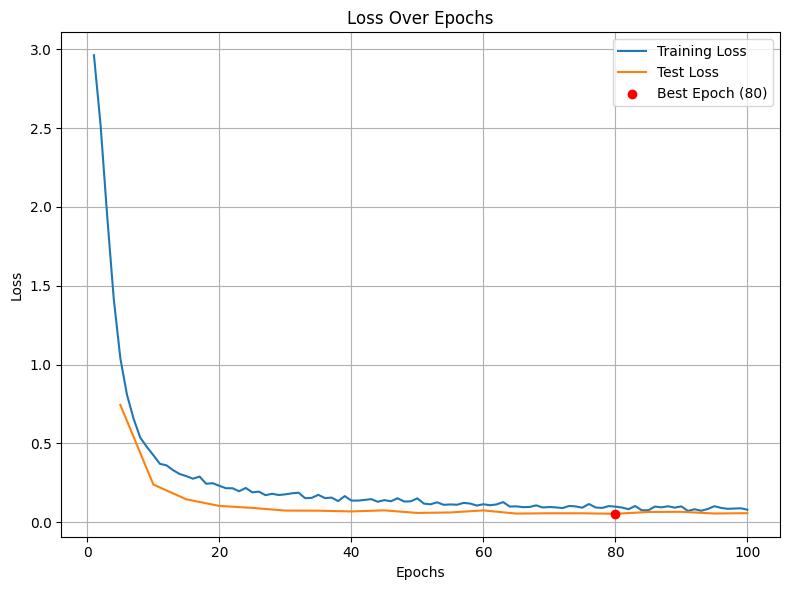

In [91]:
## Loss Curve

## Using the train-test loss array plot the loss over epochs

epochs_range = np.arange(1, len(train_loss_arr) + 1)

# Get the best epoch and corresponding loss value
best_epoch = early_stopper.best_epoch
best_loss = early_stopper.best_loss

## Get the numpy array to mask nan vals
test_loss_np = np.array(test_loss_arr, dtype=np.float32)
# Get only the valid test loss values (non-NaN)
valid_indices = ~np.isnan(test_loss_np)
valid_test_epochs = epochs_range[valid_indices]
valid_test_loss = test_loss_np[valid_indices]


plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_loss_arr, label='Training Loss')
plt.plot(valid_test_epochs,valid_test_loss, label='Test Loss')

# Highlight the best epoch
plt.scatter(best_epoch , best_loss, color='red', label=f'Best Epoch ({best_epoch})', zorder=5)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


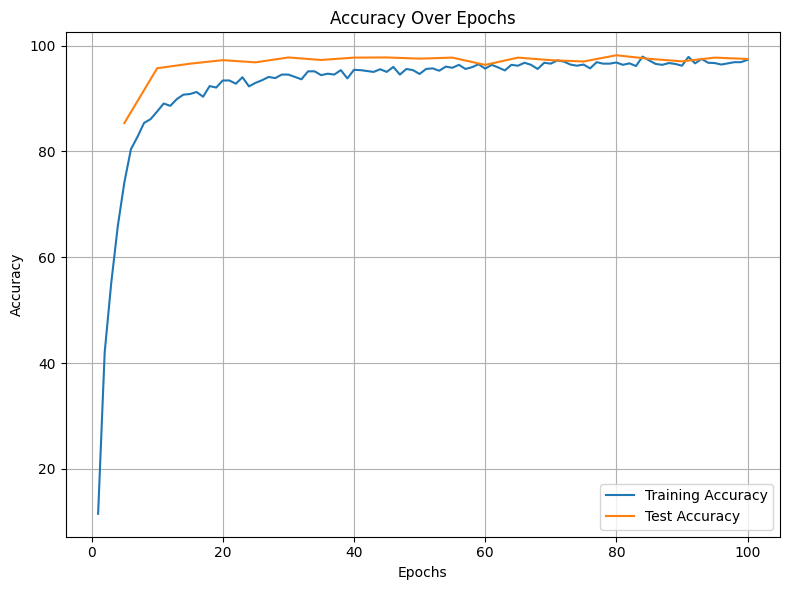

In [92]:
## Accuracy Curve
# Plotting
epochs_range = np.arange(1, len(train_acc_arr) + 1)


## Get the numpy array to mask nan vals
test_acc_np = np.array(test_acc_arr, dtype=np.float32)
# Get only the valid test loss values (non-NaN)
valid_indices = ~np.isnan(test_acc_np)
valid_test_epochs = epochs_range[valid_indices]
valid_test_acc = test_acc_np[valid_indices]

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_acc_arr, label='Training Accuracy')
plt.plot(valid_test_epochs, valid_test_acc, label='Test Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Inference

In [93]:
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


In [94]:
def make_predictions(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    y_preds = []
    y_true = []

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Making predictions..."):
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_logit = model(X)

            # Get prediction probabilities and predicted labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

            # Collect predictions and true labels
            y_preds.append(y_pred.cpu())
            y_true.append(y.cpu())

    # Combine all predictions and true labels into tensors
    y_preds = torch.cat(y_preds)
    y_true = torch.cat(y_true)

    return y_preds, y_true


In [95]:
y_preds_test,y_true_test=make_predictions(model=model,
                 dataloader=val_loader)

Making predictions...: 100%|██████████| 7/7 [00:00<00:00, 360.80it/s]


In [96]:
confmat = ConfusionMatrix(num_classes=len(le.classes_),task="multiclass")

confmat_tensor=confmat(preds=y_preds_test,target=y_true_test)


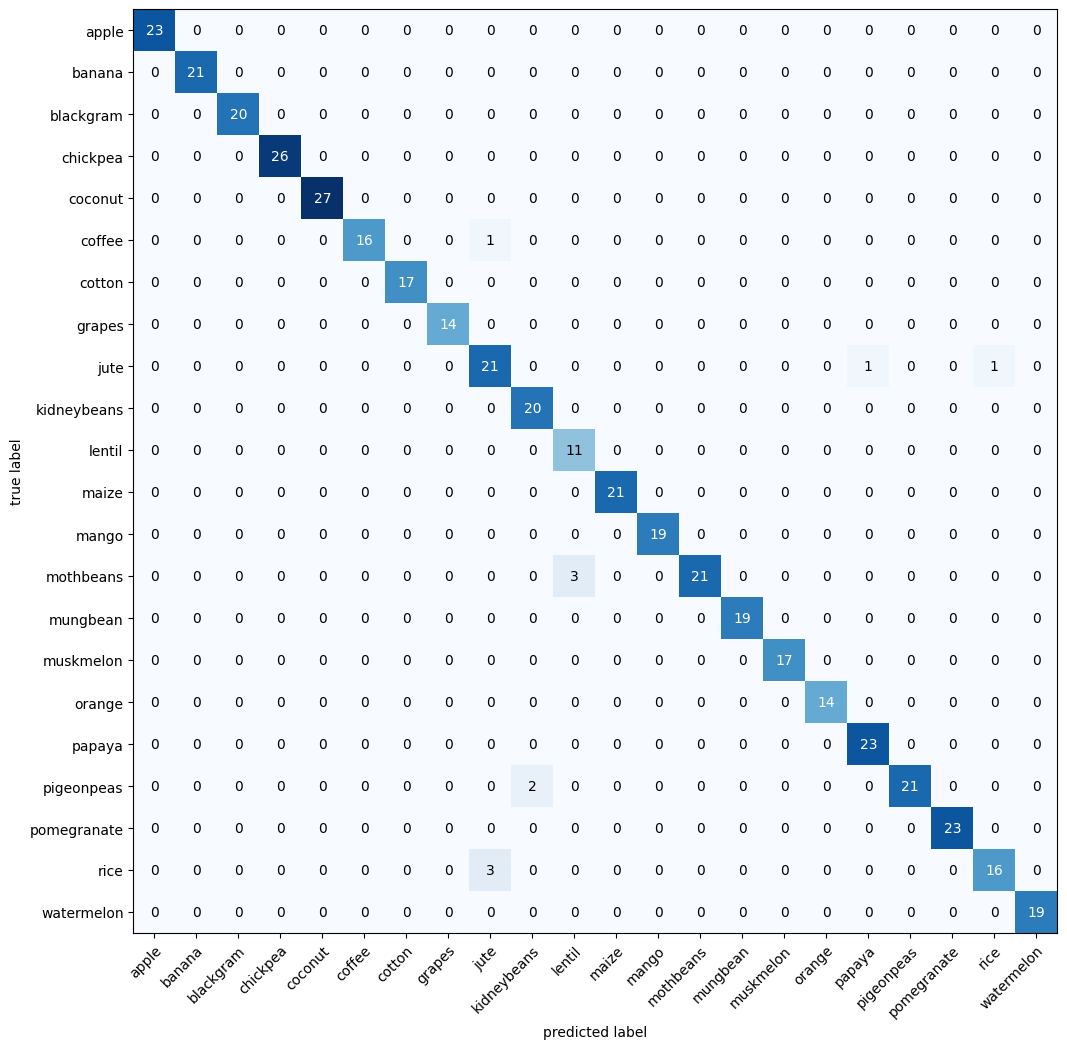

In [97]:
## Plot the confusion matrix



fig,ax=plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                           figsize=(15,12),
                           class_names=le.classes_)

plt.show()

In [98]:
## Metrics

precision = precision_score(y_true_test, y_preds_test, average='weighted')
recall = recall_score(y_true_test, y_preds_test, average='weighted')
f1 = f1_score(y_true_test, y_preds_test, average='weighted')
accuracy=accuracy_score(y_true_test, y_preds_test)


print(f"Precision for Testing Data: {precision:.4f}")
print(f"Recall for Testing Data: {recall:.4f}")
print(f"F1-score for Testing Data: {f1:.4f}")
print(f"Accuracy for Testing Data: {accuracy:.4f}")

Precision for Testing Data: 0.9774
Recall for Testing Data: 0.9750
F1-score for Testing Data: 0.9752
Accuracy for Testing Data: 0.9750


### Saving the Model

In [8]:
import os
os.makedirs(os.path.join(os.getcwd(),"models"),exist_ok=True)
MODEL_NAME="crop_recommendation_model.pt"
MODEL_PATH=os.path.join(os.getcwd(),"models",MODEL_NAME)

In [100]:
print(f"Saving model to: {MODEL_PATH}")
torch.save(obj=model.state_dict(),f=MODEL_PATH)

Saving model to: c:\Users\nirma\OneDrive\Desktop\EPICS\Crop Recommendation\models\crop_recommendation_model.pt


In [9]:
## Loading Model

loaded_model=TabularNet(input_dim=7,output_dim=22).to(device)
loaded_model.load_state_dict(torch.load(f=MODEL_PATH, weights_only=True))

<All keys matched successfully>

In [10]:
loaded_model.eval()
with torch.no_grad():
    logits = loaded_model(torch.tensor([5.1, 3.5, 1.4, 0.2, 0.8, 2.3, 1.1],dtype=torch.float32).unsqueeze(0))

logits

tensor([[ -0.2049,  22.6507, -42.4419, -24.9634, -53.0019, -33.6169,  -9.1968,
           6.4448,  -7.3792, -39.5985, -43.5422, -41.4738, -72.2004, -45.8508,
         -33.3523, -29.9237, -19.3804, -11.8950, -25.7278, -43.8373,   0.5906,
         -36.8051]])

In [ ]:
torch.argmax(logits, dim=1).item()


1

In [29]:
# Get top 3 class indices and scores
import torch.nn.functional  as F

probs = F.softmax(logits, dim=1)
topk_values, topk_indices = torch.topk(probs, k=3, dim=1)
topk_values,topk_indices

(tensor([[1.0000e+00, 9.1595e-08, 2.6269e-10]]), tensor([[ 1,  7, 20]]))

In [36]:
topk_indices.tolist()[0]

[1, 7, 20]

In [37]:
# Flatten to 1D lists
topk_indices = topk_indices.tolist()[0]
topk_values = topk_values.tolist()[0]
# Decode class names
topk_labels = le.inverse_transform(topk_indices)
topk_labels

array(['banana', 'grapes', 'rice'], dtype=object)

In [42]:
# Combine into a list of (label, probability) pairs
topk_predictions = [
    {"label": label, "probability": round(float(prob), 4)}
    for label, prob in zip(topk_labels, topk_values)
]

topk_predictions

[{'label': 'banana', 'probability': 1.0},
 {'label': 'grapes', 'probability': 0.0},
 {'label': 'rice', 'probability': 0.0}]

In [111]:
pred_idx = torch.argmax(logits, dim=1).item()
le.inverse_transform([pred_idx])[0]


'banana'

In [14]:
def infer(input_list,loaded_model,label_encoder,preprocessor):
    """
    Takes a list of 7 numeric features and returns the predicted class label.
    """
    # Validate input length
    assert len(input_list) == 7, "Input must have exactly 7 features."

    # Convert to 2D DataFrame
    input_df = pd.DataFrame([input_list], columns=["N","P","K","temperature","humidity","ph","rainfall"])

    # Preprocess
    processed_input = preprocessor.transform(input_df)

    # Convert to tensor
    input_tensor = torch.tensor(processed_input, dtype=torch.float32).to(device)

    # Predict
    loaded_model.eval()
    with torch.no_grad():
        logits = loaded_model(input_tensor)
        pred_idx = torch.argmax(logits, dim=1).item()

    # Decode label
    predicted_label = label_encoder.inverse_transform([pred_idx])[0]

    return predicted_label

In [16]:
new_data = [25,64,20,33.15122581,32.45974539,4.807776748999999,105.03802749999998]  # example input
prediction = infer(new_data,loaded_model,le,preprocessor)
print("Predicted class:", prediction)


Predicted class: pigeonpeas
